In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
# from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from tqdm import tqdm_notebook
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import pickle
from google.colab import auth
auth.authenticate_user()

In [2]:
data_path = 'gs://dataprep-staging-a351fd7d-4575-4a19-86f3-a0e85c39fc88/nataliia.shcheglovaa@gmail.com/jobrun/Capstone_3_data/trips_no_geom.csv'
data = pd.read_csv(data_path, storage_options={'token': 'cloud'}, encoding='latin-1', engine='c')

In [3]:
data.head()

,request_date,request_hour,hvfhs_license_num,PULocationID,passenger_count,avg_passenger_wait_time,avg_congestion_surcharge,temp,dew,humidity,...,cloudcover,rain,snow,request_month,request_day,request_day_of_week,morning_time_request,night_time_request,day_time_request,evening_time_request
0,2021-01-01,0,HV0003,3,68,6.790931,0.080882,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
1,2021-01-01,0,HV0003,4,100,4.221833,2.722500,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
2,2021-01-01,0,HV0003,5,14,10.142857,0.000000,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
3,2021-01-01,0,HV0003,6,18,7.538889,0.152778,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
4,2021-01-01,0,HV0003,7,195,3.579316,0.394872,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0


In [4]:
data['request_datetime'] = pd.to_datetime(data['request_date'].astype(str)+' '+ data['request_hour'].astype(str)+':00:00')
data.head()

,request_date,request_hour,hvfhs_license_num,PULocationID,passenger_count,avg_passenger_wait_time,avg_congestion_surcharge,temp,dew,humidity,...,rain,snow,request_month,request_day,request_day_of_week,morning_time_request,night_time_request,day_time_request,evening_time_request,request_datetime
0,2021-01-01,0,HV0003,3,68,6.790931,0.080882,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
1,2021-01-01,0,HV0003,4,100,4.221833,2.722500,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
2,2021-01-01,0,HV0003,5,14,10.142857,0.000000,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
3,2021-01-01,0,HV0003,6,18,7.538889,0.152778,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
4,2021-01-01,0,HV0003,7,195,3.579316,0.394872,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01


In [5]:
data['request_date'] = pd.to_datetime(data['request_date'])
data['request_date'] = data['request_date'].dt.date

# SARIMA model with weather features as exogenous variables

My data is time series with three levels of seasonality: hourly (rush hours vs night hours), daily (weekends vs weekdays) and monthly (last 3 months of the year being more busy). Additionally, weather factors and zone also play a role. I'll try to create a SARIMA model that incorporates all of these.

A note about pickup zones as predictor features: since my data is huge and including zones increases computational resources needed, for this project I will predict the demand for one zone only. In real life setting I would either:

a) dummy-encode zones and include them as predictor features, or

b) train a separate model for each zone.

In [6]:
# Selecting sample of data for one zone only due to huge amount of data
data_sample = data.loc[data['PULocationID']==231,['request_datetime','request_date','request_hour','passenger_count','temp','dew','humidity','precip','cloudcover','rain','snow']]
data_sample.head()

,request_datetime,request_date,request_hour,passenger_count,temp,dew,humidity,precip,cloudcover,rain,snow
221,2021-01-01 00:00:00,2021-01-01,0,187,2.5,-3.0,67.8,15.33,50.6,1,0
474,2021-01-01 01:00:00,2021-01-01,1,201,2.5,-3.0,67.8,15.33,50.6,1,0
723,2021-01-01 02:00:00,2021-01-01,2,141,2.5,-3.0,67.8,15.33,50.6,1,0
969,2021-01-01 03:00:00,2021-01-01,3,70,2.5,-3.0,67.8,15.33,50.6,1,0
1219,2021-01-01 04:00:00,2021-01-01,4,48,2.5,-3.0,67.8,15.33,50.6,1,0


In [7]:
data_sample['request_datetime'] = pd.to_datetime(data_sample['request_datetime'])
data_sample.set_index('request_datetime', inplace=True)
data_sample = data_sample[~data_sample.index.duplicated(keep='first')]  # Removing duplicate indices
data_sample = data_sample.resample('h').ffill()

In [8]:
size = int(len(data_sample) * 0.9)
train, test = data_sample[0:size], data_sample[size:len(data_sample)]
print(train.shape, test.shape)

(7884, 10) (876, 10)


In [ ]:
# Checking if data is stationary
y_train_sar = train['passenger_count']
y_train_sar = pd.Series(y_train_sar, index=train.index)
result = sm.tsa.stattools.adfuller(y_train_sar)
print('Dickey-Fuller: p={0:.5f}'.format(result[1]))

Dickey-Fuller: p=0.00000


Null hypothesis for Dickey_Fuller test is that data is non-stationary. Given the p-value of 0 we rejact the null hypothesis.
The test suggests that the data is stationary.

<Figure size 1000x500 with 0 Axes>

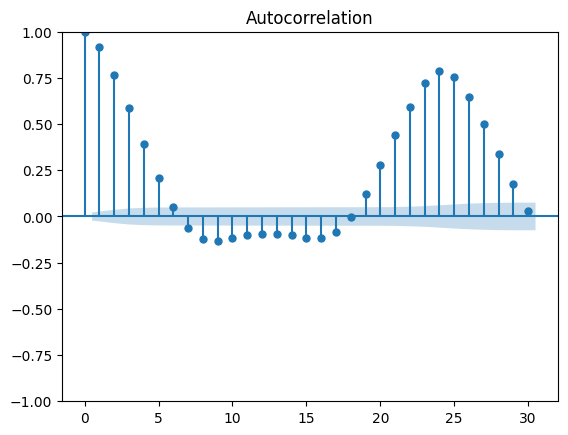

<Figure size 1000x500 with 0 Axes>

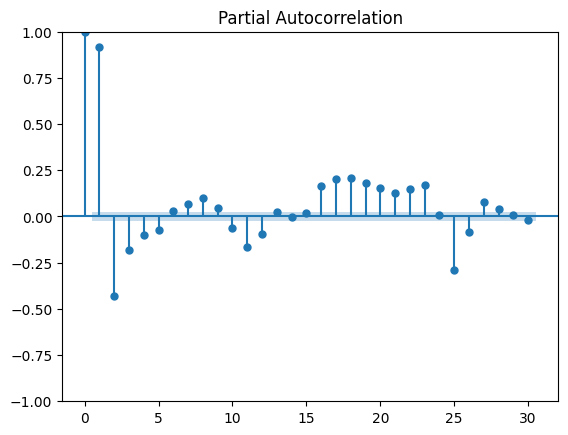

In [ ]:
# Checking for autocorrelation and seasonality
plt.figure(figsize=(10, 5))
plot_acf(y_train_sar, lags=30)  # ACF for first 30 lags
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(y_train_sar, lags=30)  # PACF for first 30 lags
plt.show()

ACF plot suggests that my time series have strong autocorrelation at shorter lags, a daily pattern (there's a spike at lag 24), and possible trend-like behavior (there's a slow decay of ACF).

PACF:
After lag 1, the partial autocorrelation drops significantly, which suggests
that current value is greatly influenced by the number of trip requests in the previous hour.

In [ ]:
# Creating Fourier terms for daily, weekly, and yearly seasonality
fourier = CalendarFourier(freq='YE', order=3)  # Yearly seasonality
dp = DeterministicProcess(
    index=train.index,
    constant=True,               # intercept term
    order=1,                     # trend (linear)
    seasonal=True,               # weekly seasonality
    additional_terms=[fourier],  # yearly seasonality via Fourier terms
    drop=True,                   # drop missing dates
)

In [ ]:
X_time = dp.in_sample()

In [ ]:
# Including weather features as exogenous variables
exog_features = pd.concat([X_time, train[['temp','dew','humidity','cloudcover','rain','snow']]], axis=1)
exog_features = exog_features.replace([np.inf, -np.inf], np.nan)
exog_features = exog_features.ffill()


In [ ]:
# Fitting SARIMAX model
sarimax_model = SARIMAX(
    train['passenger_count'],
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 24),   # To capture daily seasonality
    exog=exog_features)

In [ ]:
sarimax_fit = sarimax_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_start_datetime = test.index.min()

# Creating a date range for the forecast period at hourly frequency
forecast_index = pd.date_range(forecast_start_datetime, periods=len(test), freq='H')

# Preparing weather features for the forecast period
X_fore_weather = test.loc[(test['request_date'] >= forecast_start_datetime.date()) &
                          (test['request_date'] < forecast_index[-1].date()),
                          ['temp', 'dew', 'humidity', 'cloudcover', 'rain', 'snow']]
X_fore_weather = X_fore_weather.set_index(pd.to_datetime(X_fore_weather.index))
X_fore_weather = X_fore_weather.reindex(forecast_index, method='ffill')  # Fill missing values with last available data

# Preparing the time-based Fourier terms for the forecast period
X_fore_time = dp.out_of_sample(steps=len(forecast_index))

# Concatenating weather data with Fourier terms for use in the SARIMAX forecast
X_fore = pd.concat([X_fore_weather.reset_index(drop=True), X_fore_time.reset_index(drop=True)], axis=1)
X_fore.index = forecast_index

<ipython-input-31-c897f1f46b7e>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(forecast_start_datetime, periods=len(test), freq='H')


In [ ]:
# Making predictions
forecast = sarimax_fit.get_forecast(steps=876, exog=X_fore)
forecast_ci = forecast.conf_int()

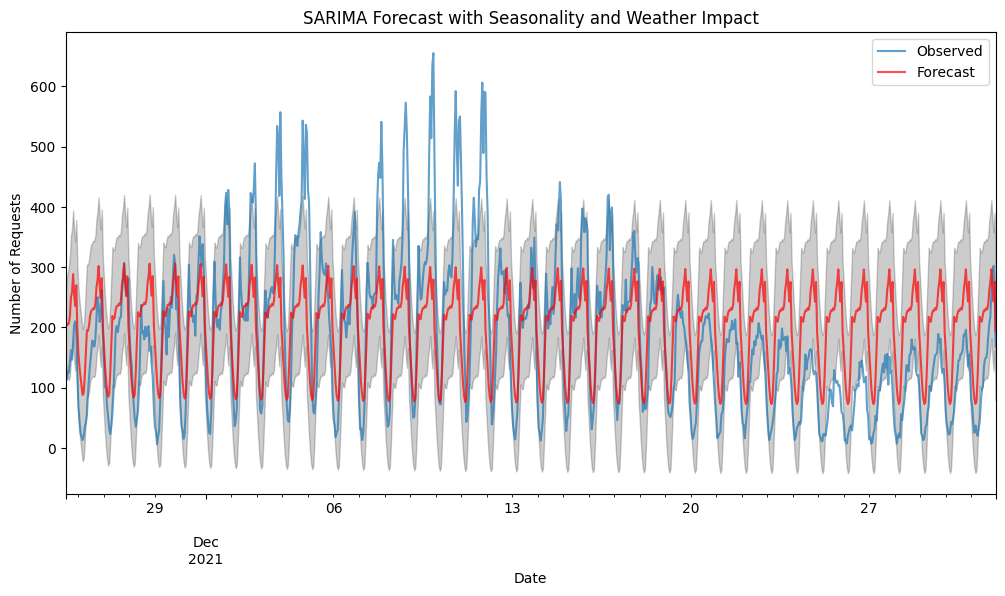

In [ ]:
# Plotting the observed data and forecast
y_test_sar = test['passenger_count']
plt.figure(figsize=(12, 6))
y_test_sar.plot(label='Observed', alpha=0.7)
forecast.predicted_mean.plot(label='Forecast', color='red', alpha=0.7)
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.title('SARIMA Forecast with Seasonality and Weather Impact')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [ ]:
mae_sarimax = mean_absolute_error(y_test_sar, forecast.predicted_mean)
mse_sarimax = mean_squared_error(y_test_sar, forecast.predicted_mean)
rmse_sarimax = mse_sarimax ** 0.5

print(f'SARIMAX MAE: {mae_sarimax}, RMSE: {rmse_sarimax}')

SARIMAX MAE: 77.5888220032018, RMSE: 99.48216038006491


In [ ]:
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    passenger_count   No. Observations:                 7884
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -37456.670
Date:                            Sat, 19 Oct 2024   AIC                          74997.341
Time:                                    04:50:38   BIC                          75290.062
Sample:                                01-01-2021   HQIC                         75097.623
                                     - 11-25-2021                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0001   6827.164   2.08e-08      1.000   -1.34e+04    1.34e+04
trend                 -0.0002      0.008     -0.032      0.975      -0.015       0.015
s(2,24)            -1.371e-05   7779.958  -1.76e-09      1.000   -1.52e+04    1.52e+04
s(3,24)            -9.747e-06   8925.438  -1.09e-09      1.000   -1.75e+04    1.75e+04
s(4,24)             -4.67e-06   8276.975  -5.64e-10      1.000   -1.62e+04    1.62e+04
s(5,24)            -3.075e-06   1.09e+04  -2.81e-10      1.000   -2.14e+04    2.14e+04
s(6,24)            -1.103e-07   1.02e+04  -1.08e-11      1.000   -1.99e+04    1.99e+04
s(7,24)             2.377e-06   5172.311    4.6e-10      1.000   -1.01e+04    1.01e+04
s(8,24)             4.949e-06   8060.852   6.14e-10      1.000   -1.58e+04    1.58e+04
s(9,24)             8.911e-06   7942.257   1.12e-09      1.000   -1.56e+04    1.56e+04
s(10,24)            8.128e-06   9125.744   8.91e-10      1.000   -1.79e+04    1.79e+04
s(11,24)            7.813e-06   8536.668   9.15e-10      1.000   -1.67e+04    1.67e+04
s(12,24)            7.719e-06   7556.784   1.02e-09      1.000   -1.48e+04    1.48e+04
s(13,24)            8.445e-06   9804.215   8.61e-10      1.000   -1.92e+04    1.92e+04
s(14,24)            7.884e-06   8538.763   9.23e-10      1.000   -1.67e+04    1.67e+04
s(15,24)            7.939e-06   8310.194   9.55e-10      1.000   -1.63e+04    1.63e+04
s(16,24)            8.103e-06   6739.840    1.2e-09      1.000   -1.32e+04    1.32e+04
s(17,24)            8.478e-06   6104.551   1.39e-09      1.000    -1.2e+04     1.2e+04
s(18,24)            1.151e-05   5887.105   1.95e-09      1.000   -1.15e+04    1.15e+04
s(19,24)             1.41e-05   6021.597   2.34e-09      1.000   -1.18e+04    1.18e+04
s(20,24)            1.519e-05   5208.008   2.92e-09      1.000   -1.02e+04    1.02e+04
s(21,24)            1.418e-05   6650.222   2.13e-09      1.000    -1.3e+04     1.3e+04
s(22,24)            1.586e-05   6099.596    2.6e-09      1.000    -1.2e+04     1.2e+04
s(23,24)            1.689e-05   8252.415   2.05e-09      1.000   -1.62e+04    1.62e+04
s(24,24)             1.72e-05   9720.819   1.77e-09      1.000   -1.91e+04    1.91e+04
sin(1,freq=YE-DEC)   -21.5949     20.514     -1.053      0.292     -61.801      18.611
cos(1,freq=YE-DEC)   -16.8686      9.049     -1.864      0.062     -34.605       0.868
sin(2,freq=YE-DEC)   -21.4227      9.235     -2.320      0.020     -39.524      -3.321
cos(2,freq=YE-DEC)   -28.1869      6.672     -4.225      0.000     -41.264     -15.110
sin(3,freq=YE-DEC)    10.5194      6.091      1.727      0.084      -1.419      22.457
cos(3,freq=YE-DEC)   -21.0334      5.761     -3.651      0.000     -32.324      -9.742
temp                  -1.8310      2.024     -0.905      0.366      -5.797       2.135
dew                    2.1702      2.190      0.991      0.322      -2.122       6.462
h

This looks like quite a bad model with very high AIC. It overestimates the demand at low season and underestimates at high season.

# Linear regression

In [35]:
# Preparing data for linear regression
data_lr = data.loc[data['PULocationID']==231,['request_datetime','request_month','request_day','request_hour','request_day_of_week','morning_time_request','evening_time_request','day_time_request','night_time_request','passenger_count','temp','dew','humidity','precip','cloudcover','rain','snow']]
data_lr['request_datetime'] = pd.to_datetime(data_lr['request_datetime'])
data_lr.set_index('request_datetime', inplace=True)
data_lr = data_lr[~data_lr.index.duplicated(keep='first')]
data_lr.head()

,request_month,request_day,request_hour,request_day_of_week,morning_time_request,evening_time_request,day_time_request,night_time_request,passenger_count,temp,dew,humidity,precip,cloudcover,rain,snow
request_datetime,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1,1,0,4,0,0,0,1,187,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 01:00:00,1,1,1,4,0,0,0,1,201,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 02:00:00,1,1,2,4,0,0,0,1,141,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 03:00:00,1,1,3,4,0,0,0,1,70,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 04:00:00,1,1,4,4,0,0,0,1,48,2.5,-3.0,67.8,15.33,50.6,1,0


In [36]:
# Since my data has autocorrelation, I'm creating lagged variables as additional features - number of uber requests in the previous hour
# and number of requests at this time previous day
data_lr['lag_1'] = data_lr['passenger_count'].shift(1)
data_lr['lag_24'] = data_lr['passenger_count'].shift(24)

In [37]:
data_lr = data_lr.dropna()

In [38]:
data_lr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8735 entries, 2021-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   request_month         8735 non-null   int64  
 1   request_day           8735 non-null   int64  
 2   request_hour          8735 non-null   int64  
 3   request_day_of_week   8735 non-null   int64  
 4   morning_time_request  8735 non-null   int64  
 5   evening_time_request  8735 non-null   int64  
 6   day_time_request      8735 non-null   int64  
 7   night_time_request    8735 non-null   int64  
 8   passenger_count       8735 non-null   int64  
 9   temp                  8735 non-null   float64
 10  dew                   8735 non-null   float64
 11  humidity              8735 non-null   float64
 12  precip                8735 non-null   float64
 13  cloudcover            8735 non-null   float64
 14  rain                  8735 non-null 

In [39]:
X = data_lr.drop('passenger_count', axis=1)
y = data_lr['passenger_count']

In [40]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [41]:
X_train = X_scaled.iloc[:int(len(data_lr)*0.9)]
X_test = X_scaled.iloc[int(len(data_lr)*0.9):]
print(train.shape, test.shape)

(7884, 10) (876, 10)


In [42]:
y_train = y.iloc[:int(len(data_lr)*0.9)]
y_test = y.iloc[int(len(data_lr)*0.9):]
print(train.shape, test.shape)

(7884, 10) (876, 10)


In [43]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred = model_lr.predict(X_test)

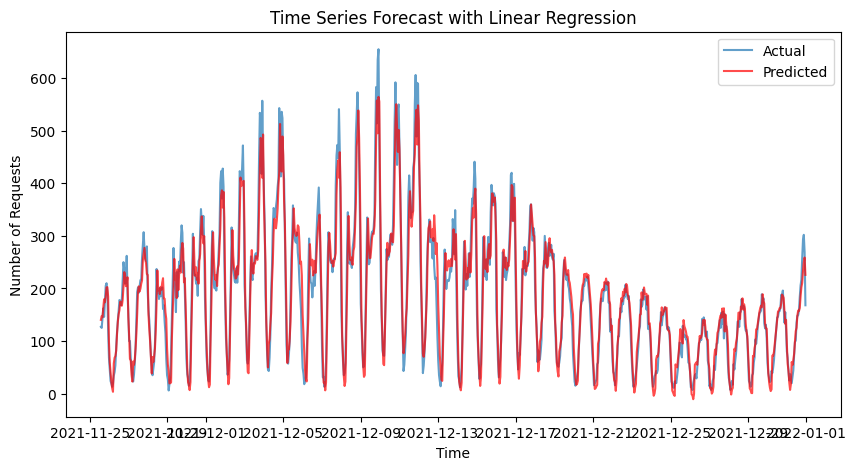

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with Linear Regression')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [45]:
# Checking model's performance
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = mse_linear ** 0.5
r2_linear = r2_score(y_test, y_pred)
print(f'Linear Regression MAE: {mae_linear}, MSE: {mse_linear}, RMSE: {rmse_linear}, R2: {r2_linear}')

Linear Regression MAE: 27.558813125654805, MSE: 1393.396932917473, RMSE: 37.32823238404777, R2: 0.9135561427392708


In [21]:
# Calculating AIC index
n = X_test.shape[0]
k = X_test.shape[1] + 1
rss = np.sum((y_test - y_pred) ** 2)
log_likelihood = -n / 2 * (np.log(2 * np.pi * (rss / n)) + 1)
aic = 2 * k - 2 * log_likelihood
print(f'AIC: {aic}')

AIC: 8843.627452423398


MAE, RMSE & AIC are much smaller than in SARIMAX model. R-squared of 0.91 indicates a very good performance.

In [ ]:
intercept = model_lr.intercept_
coefficients = model_lr.coef_

coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

print(f"Intercept: {intercept}")
print(coeff_df)

Intercept: 164.2760755874855
                 Feature   Coefficient
0          request_month  1.055329e+00
1            request_day -1.374560e-01
2           request_hour -1.342951e+01
3    request_day_of_week -3.176237e+00
4   morning_time_request  4.161829e+14
5   evening_time_request  4.161829e+14
6       day_time_request  4.161829e+14
7     night_time_request  4.161194e+14
8                   temp -3.724309e+00
9                    dew  4.323833e+00
10              humidity -2.054570e+00
11                precip -4.637700e-02
12            cloudcover  3.994618e-03
13                  rain  2.360498e-02
14                  snow -1.009047e+00
15                 lag_1  7.497796e+01
16                lag_24  2.073987e+01


### Linear regression with only one lagged feature
In practice it may be hard to feed model with number of requests in the previous hour. I'll create linear model with only one lagged feature - number of requests in the same hour previous day.

In [46]:
X2 = data_lr.drop(['passenger_count','lag_1'], axis=1)
y2 = data_lr['passenger_count']

X2_scaled = scaler.fit_transform(X2)
X2_scaled = pd.DataFrame(X2_scaled,columns=X2.columns)

X2_train = X2_scaled.iloc[:int(len(data_lr)*0.9)]
X2_test = X2_scaled.iloc[int(len(data_lr)*0.9):]

y2_train = y2.iloc[:int(len(data_lr)*0.9)]
y2_test = y2.iloc[int(len(data_lr)*0.9):]

model_lr2 = LinearRegression()
model_lr2.fit(X2_train, y2_train)

LinearRegression()

In [47]:
y2_pred = model_lr2.predict(X2_test)

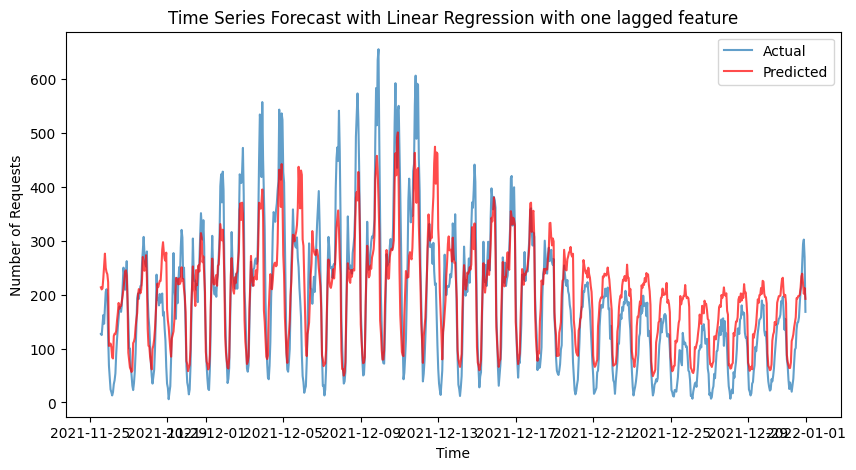

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y2_test.index, y2_test, label='Actual', alpha=0.7)
plt.plot(y2_test.index, y2_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with Linear Regression with one lagged feature')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [48]:
mae_linear2 = mean_absolute_error(y2_test, y2_pred)
mse_linear2 = mean_squared_error(y2_test, y2_pred)
rmse_linear2 = mse_linear2 ** 0.5
r2_linear2 = r2_score(y2_test, y2_pred)
print(f'Linear Regression (with one lagged feature) MAE: {mae_linear2}, MSE: {mse_linear2}, RMSE: {rmse_linear2}, R2: {r2_linear2}')

Linear Regression (with one lagged feature) MAE: 55.008905544337566, MSE: 5287.854550583207, RMSE: 72.71763576040689, R2: 0.6719509472228863


In [25]:
# Calculating AIC index
n = X2_test.shape[0]
k = X2_test.shape[1] + 1
rss = np.sum((y2_test - y2_pred) ** 2)
log_likelihood = -n / 2 * (np.log(2 * np.pi * (rss / n)) + 1)
aic = 2 * k - 2 * log_likelihood
print(f'AIC: {aic}')

AIC: 10007.253279307693


As expected, linear model with only one lagged feature has a worse performance, but it could be easier to operationalize this model. The oerformance is still much better than SARIMA's model (lower AIC, MAE & RMSE).

# XGBoost Regression
I'll be using the same data as for Linear regression

In [32]:
model_xgb = XGBRegressor()
model_xgb.fit(X2_train, y2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
y3_pred = model_xgb.predict(X2_test)

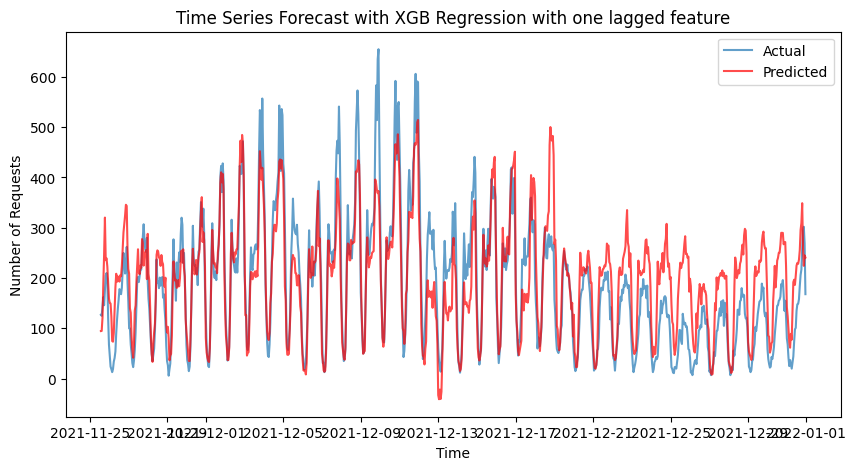

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y2_test.index, y2_test, label='Actual', alpha=0.7)
plt.plot(y2_test.index, y3_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with XGB Regression with one lagged feature')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [34]:
mae_xgb = mean_absolute_error(y2_test, y3_pred)
mse_xgb = mean_squared_error(y2_test, y3_pred)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y2_test, y3_pred)
print(f'XGB Regression (with one lagged feature) MAE: {mae_xgb}, MSE: {mse_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}')

XGB Regression (with one lagged feature) MAE: 54.18656651924622, MSE: 4917.906357133489, RMSE: 70.12778591352709, R2: 0.6949018239974976


XGB model with one lagged feature (previous day trip requests) produced a better R2 score than linear regression with one lagged feature.

### Hyperparameters optimization

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_squared_error',  # Scoring metric for regression
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X2_train, y2_train)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", -random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'colsample_bytree': 0.8452413703502375, 'gamma': 0.31164906341377896, 'learning_rate': 0.10926940745579475, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 111, 'reg_alpha': 0.32518332202674705, 'reg_lambda': 0.7296061783380641, 'subsample': 0.8187787356776066}
Best cross-validation score:  1467.847689184385


### Creating a model with optimized parameters

In [49]:
model_xgb = XGBRegressor(colsample_bytree=0.8452413703502375,
                         gamma=0.31164906341377896,
                         learning_rate=0.10926940745579475,
                         max_depth=9,
                         min_child_weight=7,
                         n_estimators=111,
                         reg_alpha=0.32518332202674705,
                         reg_lambda=0.7296061783380641,
                         subsample=0.8187787356776066)
model_xgb.fit(X2_train, y2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8452413703502375, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.31164906341377896,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10926940745579475,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=111, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
y3_pred = model_xgb.predict(X2_test)

In [52]:
mae_xgb = mean_absolute_error(y2_test, y3_pred)
mse_xgb = mean_squared_error(y2_test, y3_pred)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y2_test, y3_pred)
print(f'XGB Regression (with one lagged feature) MAE: {mae_xgb}, MSE: {mse_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}')

XGB Regression (with one lagged feature) MAE: 50.20266012414369, MSE: 4589.595702826459, RMSE: 67.74655491481806, R2: 0.7152696251869202


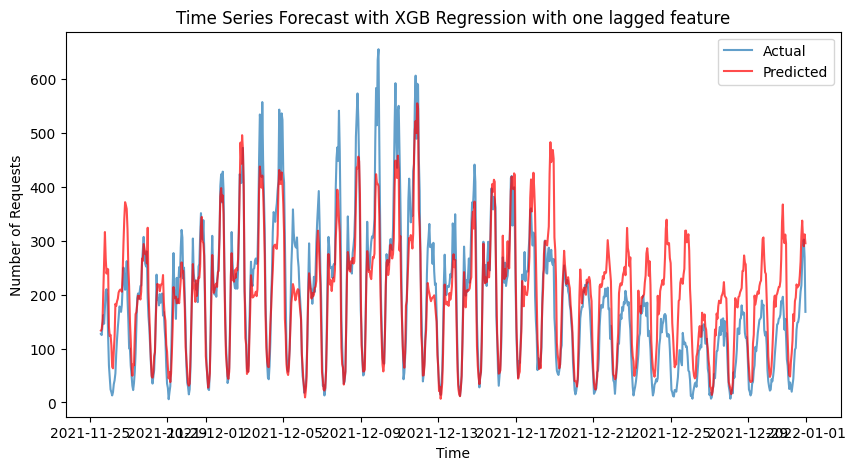

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y2_test.index, y2_test, label='Actual', alpha=0.7)
plt.plot(y2_test.index, y3_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with XGB Regression with one lagged feature')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

### Model diagnostics

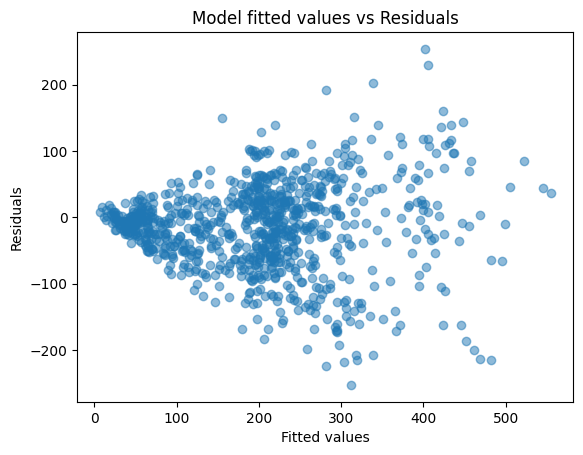

In [ ]:
# Fitted values versus residuals plot
residuals = y2_test - y3_pred
plt.scatter(y3_pred,residuals,alpha=0.5)
plt.xlabel("Fitted values")
plt.ylabel('Residuals')
plt.title('Model fitted values vs Residuals')
plt.show()

The funnel shape of fitted values vs residuals plot suggests that there is a heteroscedascity problem. I will try to log transform my target variable.

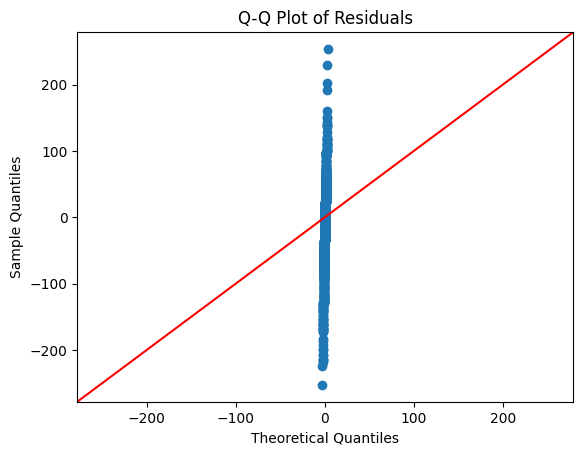

In [ ]:
# Quantile plot of the residuals
sm.qqplot(residuals, line ='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

Also, QQ plot reveals that residuals are not normaly distributed.

### Transforming target feature to log to achieve homoscedascicity

In [53]:
y2_train_log = np.log(y2_train)
y2_test_log = np.log(y2_test)

model_xgb = XGBRegressor(colsample_bytree=0.8452413703502375,
                         gamma=0.31164906341377896,
                         learning_rate=0.10926940745579475,
                         max_depth=9,
                         min_child_weight=7,
                         n_estimators=111,
                         reg_alpha=0.32518332202674705,
                         reg_lambda=0.7296061783380641,
                         subsample=0.8187787356776066)
model_xgb.fit(X2_train, y2_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8452413703502375, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.31164906341377896,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10926940745579475,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=111, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
y3_pred = model_xgb.predict(X2_test)

In [55]:
mae_xgb = mean_absolute_error(y2_test_log, y3_pred)
mse_xgb = mean_squared_error(y2_test_log, y3_pred)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y2_test_log, y3_pred)
print(f'XGB Regression (optimized) MAE: {mae_xgb}, MSE: {mse_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}')

XGB Regression (optimized) MAE: 0.3082063229462296, MSE: 0.19187854187690273, RMSE: 0.43803942959156394, R2: 0.7621027448801259


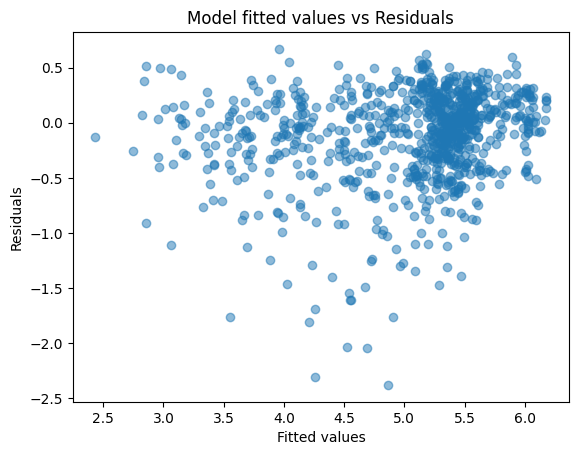

In [ ]:
# Fitted values versus residuals plot
residuals = y2_test_log - y3_pred
plt.scatter(y3_pred,residuals,alpha=0.5)
plt.xlabel("Fitted values")
plt.ylabel('Residuals')
plt.title('Model fitted values vs Residuals')
plt.show()

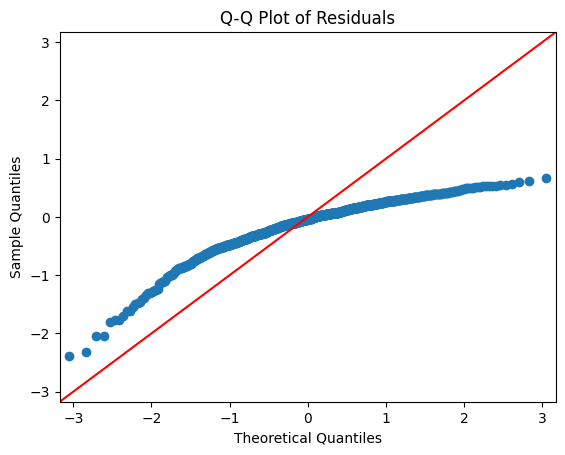

In [ ]:
# Quantile plot of the residuals
sm.qqplot(residuals, line ='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

After log transformation of target feature R2 improved significantly, residuals are randomly distributed, and QQ plot follows the line closer (residuals distribution is closer to normal). This will be my final model.

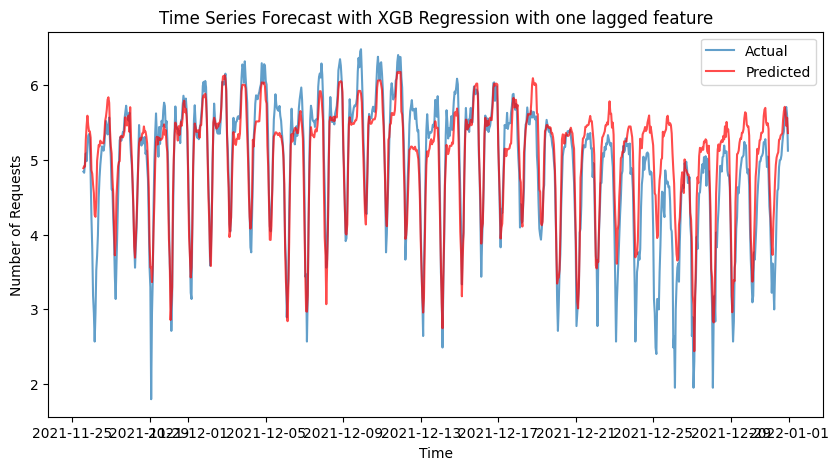

In [56]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y2_test_log.index, y2_test_log, label='Actual', alpha=0.7)
plt.plot(y2_test_log.index, y3_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with XGB Regression with one lagged feature')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

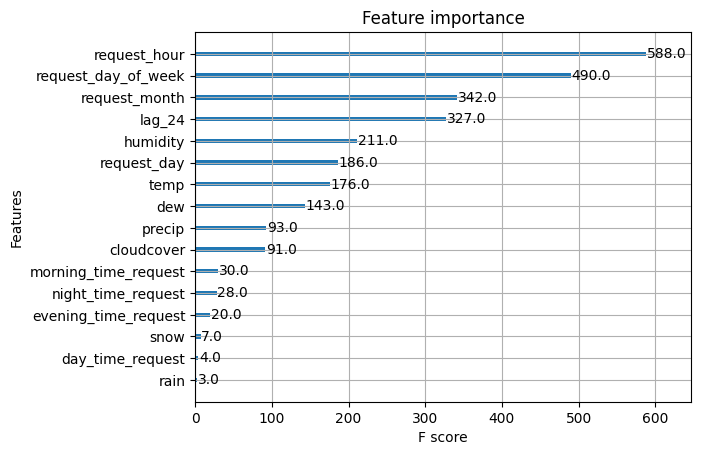

In [ ]:
from xgboost import plot_importance

plot_importance(model_xgb)
plt.show()